In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays
using Roots

In [2]:
module My

using Parameters

@with_kw struct PhysicalParam{T₁, T₂, T₃} @deftype Float64
    ħc = 197.
    mc² = 938. 
    M = ħc^2/2mc²
    
    Z::Int64 = 8
    N::Int64 = 8
    A::Int64 = Z + N
    
    # parameters for initial density
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    # parameters for ph interaction
    t₀ = -1800
    t₃ = 12871
    x₀ = 0.0
    x₃ = 0.0
    α = 1/3
    
    # parameters for pp interaction
    tp₀ = -831
    tp₃ = 6*930/0.16^1.2
    αp = 1.2
    
    Nr::Int64 = 200
    Δr = 0.1 # [fm]
    rs::T₁ = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, R/Δr) + 1
    
    # energy
    Emin = 0.0
    Emax = 50.0
    ΔE = 0.1
    Es::T₁ = range(Emin, Emax, step=ΔE)
    
    # maximal value of angular momentum
    lmax::Int64 = 5
    nstates_max::Int64 = 1000
    
    # potential
    Vs::Vector{Float64}  = zeros(Float64, Nr+1)
    Vps::Vector{Float64} = zeros(Float64, Nr+1)
    λ::Vector{Float64} = [-8.0, -8.0]; @assert length(λ) === 2
    
    # wave functions
    ys_1p::T₂ = zeros(Float64, 2, Nr+1)
    ys_2p::T₂ = zeros(Float64, 2, Nr+1)
    ys_1m::T₂ = zeros(Float64, 2, Nr+1)
    ys_2m::T₂ = zeros(Float64, 2, Nr+1)
    
    # derivative
    dys::T₂ = zeros(Float64, 2, Nr+1)
    
    # Numerov
    Gs::T₂ = zeros(Float64, 2, Nr+1)
    As::T₃     = zeros(Float64, 2, 2, Nr+1)
    As_inv::T₃ = zeros(Float64, 2, 2, Nr+1)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1 # q=1 for neutron, q=2 for proton
end

@with_kw struct Densities
    # particle densities
    ρ_q::Matrix{Float64}; @assert size(ρ_q, 2) === 2
    τ_q::Matrix{Float64}; @assert size(τ_q, 2) === 2
    ρ_tot::Vector{Float64}
    τ_tot::Vector{Float64}
    
    # pairing densities
    ρp_q::Matrix{Float64}; @assert size(ρp_q, 2) === 2
    τp_q::Matrix{Float64}; @assert size(τp_q, 2) === 2
    ρp_tot::Vector{Float64}
    τp_tot::Vector{Float64}
end

@with_kw struct HFBstates
    nstates_max::Int64
    
    # quasiparticle energies
    qpEs::Vector{Float64}
    @assert length(qpEs) === nstates_max
    
    qnums::Vector{QuantumNumbers}
    @assert length(qnums) === nstates_max
    
    # HFB wave functions
    wfs::Array{Float64, 3} 
    @assert size(wfs, 1) === 2
    @assert size(wfs, 3) === nstates_max
end

end # module My

Main.My

In [3]:
param = My.PhysicalParam()

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Matrix{Float64}, Array{Float64, 3}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  M: Float64 20.687100213219615
  Z: Int64 8
  N: Int64 8
  A: Int64 16
  r₀: Float64 1.2
  R: Float64 3.0238105197476957
  a: Float64 0.67
  ρ₀: Float64 0.13815533254504805
  t₀: Float64 -1800.0
  t₃: Float64 12871.0
  x₀: Float64 0.0
  x₃: Float64 0.0
  α: Float64 0.3333333333333333
  tp₀: Float64 -831.0
  tp₃: Float64 50314.15921851407
  αp: Float64 1.2
  Nr: Int64 200
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 31
  Emin: Float64 0.0
  Emax: Float64 50.0
  ΔE: Float64 0.1
  Es: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  lmax: Int64 5
  nstates_max: Int64 1000
  Vs: Array{Float64}((201,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 

In [5]:
function make_HFBstates(param)
    @unpack Nr, nstates_max = param 
    
    qpEs  = zeros(Float64, nstates_max)
    qpEs .= 1e10
    
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs  = zeros(Float64, 2, Nr+1, nstates_max)
    
    My.HFBstates(nstates_max, qpEs, qnums, wfs)
end

make_HFBstates (generic function with 1 method)

In [6]:
states = make_HFBstates(param)

Main.My.HFBstates
  nstates_max: Int64 1000
  qpEs: Array{Float64}((1000,)) [1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10  …  1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]
  qnums: Array{Main.My.QuantumNumbers}((1000,))
  wfs: Array{Float64}((2, 201, 1000)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]


In [7]:
function initial_density(param)
    @unpack A, N, Z, r₀, R, a, ρ₀, rs, Nr = param
    
    # particle densities
    ρ_q = zeros(Float64, Nr+1, 2)
    τ_q = zeros(Float64, Nr+1, 2)
    ρ_tot = zeros(Float64, Nr+1)
    τ_tot = zeros(Float64, Nr+1)
    
    @. ρ_q[:,1] = (ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρ_q[:,2] = (ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρ_tot = ρ_q[:,1] + ρ_q[:,2]
    
    # pairing densities
    ρp_q = zeros(Float64, Nr+1, 2)
    τp_q = zeros(Float64, Nr+1, 2)
    ρp_tot = zeros(Float64, Nr+1)
    τp_tot = zeros(Float64, Nr+1)
    
    @. ρp_q = 0.1ρ_q
    @. ρp_tot = 0.1ρ_tot
    
    return My.Densities(ρ_q, τ_q, ρ_tot, τ_tot, 
       ρp_q, τp_q, ρp_tot, τp_tot)
end

initial_density (generic function with 1 method)

In [8]:
function test_initial_density(param)
    @unpack rs = param 
    @time dens = initial_density(param)
    
    p = plot()
    
    plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
    plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
    plot!(rs, dens.ρ_tot; label="ρ_tot")
    
    plot!(rs, dens.ρp_q[:,1]; label="ρp_n")
    plot!(rs, dens.ρp_q[:,2]; label="ρp_p")
    plot!(rs, dens.ρp_tot; label="ρp_tot")
    
    display(p)
end

test_initial_density (generic function with 1 method)

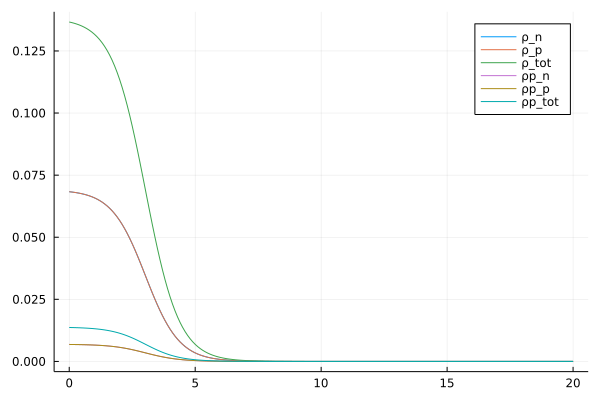

  0.000006 seconds (8 allocations: 20.312 KiB)


In [9]:
test_initial_density(param)

In [10]:
function calc_potential!(param, dens, qnum)
    @unpack M, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, rs, Vs, Vps = param
    @unpack ρ_q, ρ_tot, ρp_q, ρp_tot = dens
    @unpack l, q = qnum
    
    @views @. begin
        # t₀ term
        Vs  = t₀*((1+0.5x₀)*ρ_tot - (x₀+0.5)*ρ_q[:,q])
        
        # t₃ term
        Vs +=  1/12*t₃*(1+0.5x₃)*(α+2)*ρ_tot^(α+1)
        Vs += -1/12*t₃*(x₃+0.5)*α*(ρ_tot^(α-1))*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        Vs += -1/12*t₃*(x₃+0.5)*2*(ρ_tot^α)*ρ_q[:,q]
        
        # tp₃ term
        Vs += 1/24*tp₃*αp*ρ_tot^(αp-1)* 
                    (ρp_q[:,1]*ρp_q[:,1]+ρp_q[:,2]*ρp_q[:,2])
        
        # centrifugal potential
        Vs += M*l*(l+1)/rs^2
        
        # pairing potential
        Vps = (1/2*tp₀ + 1/12*tp₃*ρ_tot^αp)*ρp_q[:,q]
    end
end

function test_calc_potential!(param; l=0)
    @unpack rs, Vs, Vps = param
    
    dens = initial_density(param)
    
    p = plot(; ylim=(-60, 10))
    
    qnum = My.QuantumNumbers(l=l, q=1)
    @time calc_potential!(param, dens, qnum)
    plot!(rs, Vs; label="V_n")
    plot!(rs, Vps; label="Vp_n")
    
    qnum = My.QuantumNumbers(l=l, q=2)
    @time calc_potential!(param, dens, qnum)
    plot!(rs, Vs; label="V_p")
    plot!(rs, Vps; label="Vp_p")
end

test_calc_potential! (generic function with 1 method)

  0.000051 seconds
  0.000044 seconds


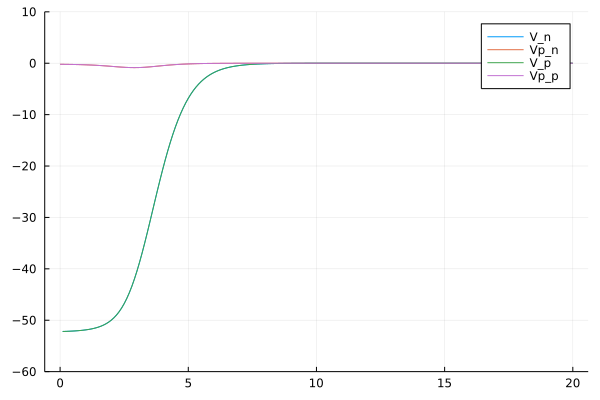

In [12]:
test_calc_potential!(param; l=0)

In [13]:
function inv2!(A_inv, A)
    d = A[1,1]*A[2,2] - A[1,2]*A[2,1]
    
    A_inv[1,1] = A[2,2]/d
    A_inv[1,2] = -A[1,2]/d
    A_inv[2,1] = -A[2,1]/d
    A_inv[2,2] = A[1,1]/d
end

function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[1,ir]^2 + ys[2,ir]^2
    end
    norm *= Δr
    norm = sqrt(norm)
    @. ys /= norm
    return 
end

function integrate_HFBeq!(param, E, qnum)
    
    @unpack M, Vs, Vps, λ, 
        Nr, Δr, rs, ir_matching, 
        ys_1p, ys_2p, ys_1m, ys_2m,
        Gs, As, As_inv = param 
    
    @unpack l, q = qnum
    
    for ir in 1:Nr+1
        As[1,1,ir] = 1 - (Δr*Δr/12)*(Vs[ir]-λ[q]-E)/M
        As[2,2,ir] = 1 - (Δr*Δr/12)*(Vs[ir]-λ[q]+E)/M 

        As[1,2,ir] = - (Δr*Δr/12)*Vps[ir]/M
        As[2,1,ir] =   (Δr*Δr/12)*Vps[ir]/M

        @views inv2!(As_inv[:,:,ir], As[:,:,ir])
    end
    
    # ourward integration (1+)
    fill!(ys_1p, 0)
    ys_1p[1,1] = 0
    ys_1p[2,1] = 0
    ys_1p[1,2] = Δr^(l+1)
    ys_1p[2,2] = 0
    
    if l !==1
        Gs[1,1] = -Δr*Δr/6
        Gs[2,1] = 0
    end
    @views mul!(Gs[:,2], As[:,:,2], ys_1p[:,2])
    
    @views for ir in 3:ir_matching+1
        @. Gs[:,ir] = 12ys_1p[:,ir-1] - 10*Gs[:,ir-1] - Gs[:,ir-2]
        mul!(ys_1p[:,ir], As_inv[:,:,ir], Gs[:,ir])
    end
    
    normalize!(ys_1p, rs)
    
    # ourward integration (2+)
    fill!(ys_2p, 0)
    ys_2p[1,1] = 0
    ys_2p[2,1] = 0
    ys_2p[1,2] = 0
    ys_2p[2,2] = Δr^(l+1)
    
    if l !==1
        Gs[1,1] = 0
        Gs[2,1] = -Δr*Δr/6
    end
    @views mul!(Gs[:,2], As[:,:,2], ys_2p[:,2])
    
    @views for ir in 3:ir_matching+1
        @. Gs[:,ir] = 12ys_2p[:,ir-1] - 10*Gs[:,ir-1] - Gs[:,ir-2]
        mul!(ys_2p[:,ir], As_inv[:,:,ir], Gs[:,ir])
    end
    
    normalize!(ys_2p, rs)
    
    # inward integration (1-)
    fill!(ys_1m, 0)
    ys_1m[1,Nr+1] = 0
    ys_1m[2,Nr+1] = 0
    ys_1m[1,Nr  ] = Δr
    ys_1m[2,Nr  ] = 0
    
    Gs[1,Nr+1] = 0
    Gs[2,Nr+1] = 0
    @views mul!(Gs[:,Nr], As[:,:,Nr], ys_1m[:,Nr])
    
    @views for ir in Nr-1: -1: ir_matching-1
        @. Gs[:,ir] = 12ys_1m[:,ir+1] - 10*Gs[:,ir+1] - Gs[:,ir+2]
        mul!(ys_1m[:,ir], As_inv[:,:,ir], Gs[:,ir])
    end
    
    normalize!(ys_1m, rs)
    
    # inward integration (2-)
    fill!(ys_2m, 0)
    ys_2m[1,Nr+1] = 0
    ys_2m[2,Nr+1] = 0
    ys_2m[1,Nr  ] = 0
    ys_2m[2,Nr  ] = Δr
    
    Gs[1,Nr+1] = 0
    Gs[2,Nr+1] = 0
    @views mul!(Gs[:,Nr], As[:,:,Nr], ys_2m[:,Nr])
    
    @views for ir in Nr-1: -1: ir_matching-1
        @. Gs[:,ir] = 12ys_2m[:,ir+1] - 10*Gs[:,ir+1] - Gs[:,ir+2]
        mul!(ys_2m[:,ir], As_inv[:,:,ir], Gs[:,ir])
    end
    
    normalize!(ys_2m, rs)
    
    return
end


function test_integrate_HFBeq!(param; E=5.6, l=0, q=1)
    @unpack rs, Nr, Δr, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    calc_potential!(param, dens, qnum)
    
    @time integrate_HFBeq!(param, E, qnum)
    
    p = plot()
    plot!(rs, param.ys_1p[1,:]; label="1+")
    plot!(rs, param.ys_1p[2,:]; label="1+")
    display(p)
    
    p = plot()
    plot!(rs, param.ys_2p[1,:]; label="2+")
    plot!(rs, param.ys_2p[2,:]; label="2+")
    display(p)
    
    p = plot()
    plot!(rs, param.ys_1m[1,:]; label="1-")
    plot!(rs, param.ys_1m[2,:]; label="1-")
    display(p)
    
    p = plot()
    plot!(rs, param.ys_2m[1,:]; label="2-")
    plot!(rs, param.ys_2m[2,:]; label="2-")
    display(p)
end

test_integrate_HFBeq! (generic function with 1 method)

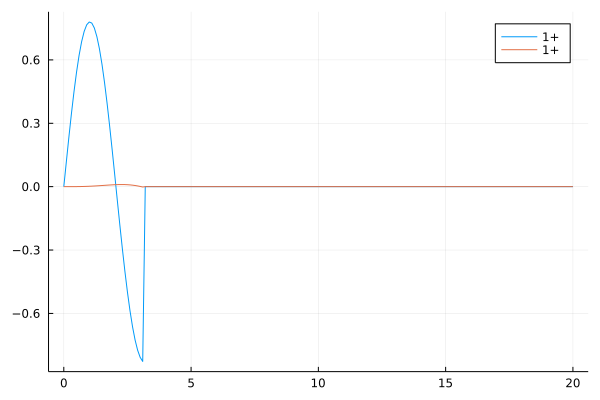

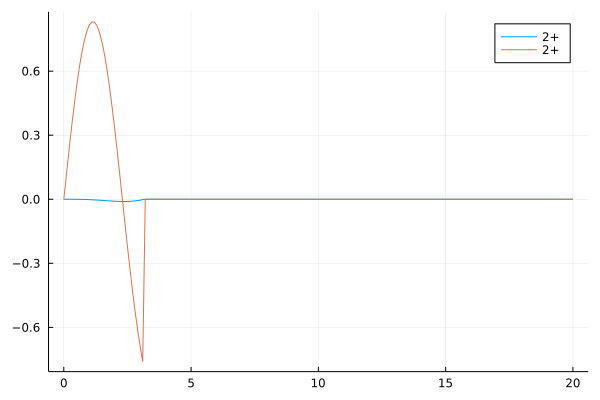

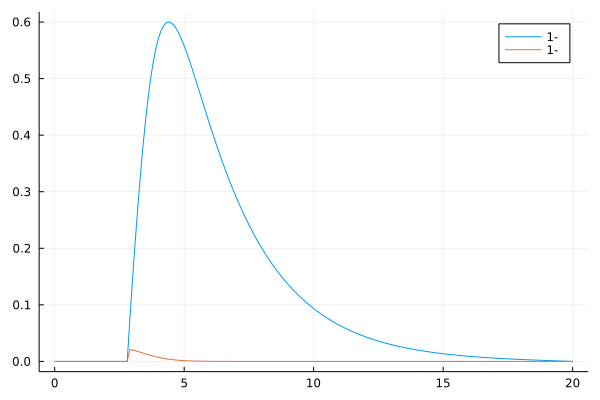

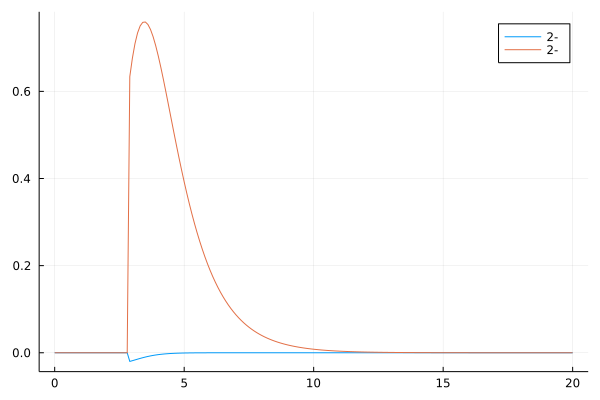

  0.000042 seconds


In [14]:
test_integrate_HFBeq!(param; E=5.0, l=0)

In [15]:
function calc_matching_matrix(param)
    @unpack Δr, ir_matching, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    ir = ir_matching
    
    M11 =  ys_1p[1,ir]
    M12 =  ys_2p[1,ir]
    M13 = -ys_1m[1,ir]
    M14 = -ys_2m[1,ir]
    
    M21 =  ys_1p[2,ir]
    M22 =  ys_2p[2,ir]
    M23 = -ys_1m[2,ir]
    M24 = -ys_2m[2,ir]
    
    M31 =  (ys_1p[1,ir+1] - ys_1p[1,ir-1])/2Δr
    M32 =  (ys_2p[1,ir+1] - ys_2p[1,ir-1])/2Δr
    M33 = -(ys_1m[1,ir+1] - ys_1m[1,ir-1])/2Δr
    M34 = -(ys_2m[1,ir+1] - ys_2m[1,ir-1])/2Δr
    
    M41 =  (ys_1p[2,ir+1] - ys_1p[2,ir-1])/2Δr
    M42 =  (ys_2p[2,ir+1] - ys_2p[2,ir-1])/2Δr
    M43 = -(ys_1m[2,ir+1] - ys_1m[2,ir-1])/2Δr
    M44 = -(ys_2m[2,ir+1] - ys_2m[2,ir-1])/2Δr
    
    M₄ = SA_F64[M11 M12 M13 M14;
                M21 M22 M23 M24;
                M31 M32 M33 M34;
                M41 M42 M43 M44]
end

function test_calc_matching_matrix!(param, Es; l=0, q=1)
    @unpack Nr, Δr = param
    
    qnum = My.QuantumNumbers(l=l, q=q)
    dets = similar(Es)
    
    dens = initial_density(param)
    calc_potential!(param, dens, qnum)
    
    for iE in 1:length(Es)
        integrate_HFBeq!(param, Es[iE], qnum)
        
        M₄ = calc_matching_matrix(param)
        
        dets[iE] = det(M₄)
        
        if iE ≥ 2 && dets[iE-1]*dets[iE] < 0
            E = Es[iE]
            @show E
        end
    end
    return dets
end

test_calc_matching_matrix! (generic function with 1 method)

E = 2.5
E = 8.8
E = 11.0
E = 14.5
E = 19.4
E = 25.4
E = 29.5
E = 32.7
E = 41.0


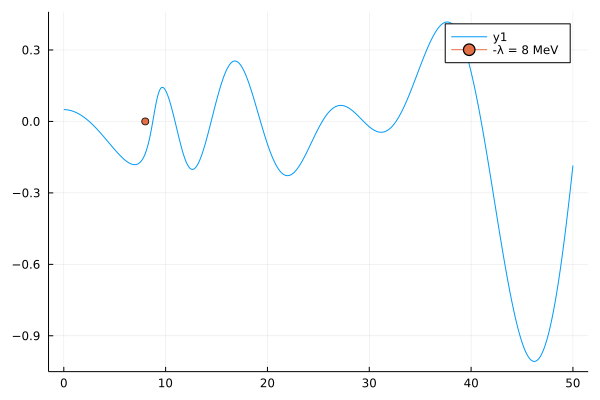

In [17]:
Es = 0:0.1:50
dets = test_calc_matching_matrix!(param, Es; l=0)
plot(Es, dets)
plot!([8],[0]; marker=:dot, label="-λ = 8 MeV")

In [18]:
function construct_eigenfunction!(ys, param, E, qnum; eps=1e-10)
    @unpack Nr, Δr, ir_matching, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    integrate_HFBeq!(param, E, qnum)
    
    M₄ = calc_matching_matrix(param)
    
    M₃ = SA_F64[M₄[2,2] M₄[2,3] M₄[2,4];
                M₄[3,2] M₄[3,3] M₄[3,4];
                M₄[4,2] M₄[4,3] M₄[4,4]]
    
    v₃ = SA_F64[-M₄[2,1], -M₄[3,1], -M₄[4,1]]
    v₃ = M₃\v₃
    
    A = 1
    B = v₃[1]
    C = v₃[2]
    D = v₃[3]
    
    a = M₄*SA_F64[A, B, C, D]
    
    if norm(a) > eps
        M₃ = SA_F64[M₄[1,1] M₄[1,3] M₄[1,4];
                    M₄[3,1] M₄[3,3] M₄[3,4];
                    M₄[4,1] M₄[4,3] M₄[4,4]]

        v₃ = SA_F64[-M₄[1,2], -M₄[3,2], -M₄[4,2]]
        v₃ = M₃\v₃

        A = v₃[1]
        B = 1
        C = v₃[2]
        D = v₃[3]
    end
    
    
    for ir in 1:ir_matching
        @views @. ys[:,ir] = A*ys_1p[:,ir] + B*ys_2p[:,ir]
    end
    for ir in ir_matching+1:Nr+1
        @views @. ys[:,ir] = C*ys_1m[:,ir] + D*ys_2m[:,ir]
    end
end


function calc_states!(states, param, dens)
    @unpack rs, Es, lmax, Vs, Vps = param 
    @unpack qpEs, qnums, wfs = states 
    
    fill!(qpEs, 1e10)
    
    istate = 0
    for l in 0:lmax, q in 1:2
        qnum = My.QuantumNumbers(l=l, q=q)
        calc_potential!(param, dens, qnum)
        
        function f(E)
            integrate_HFBeq!(param, E, qnum)
            M₄ = calc_matching_matrix(param)
            return det(M₄)
        end
        
        for i in 1:length(Es)-1
            f₁ = f(Es[i])
            f₂ = f(Es[i+1])
            
            @views if f₁*f₂ < 0
                E = find_zero(f, (Es[i], Es[i+1]), Bisection())
                istate += 1
                qpEs[istate] = E
                qnums[istate] = qnum 
                construct_eigenfunction!(wfs[:,:,istate], param, E, qnum)
                normalize!(wfs[:,:,istate], rs)
            end
        end
    end
end

function show_states(states)
    @unpack nstates_max, qpEs, qnums = states
    println("")
    for i in 1:nstates_max
        if qpEs[i] == 1e10
            break
        end
        println("i = $i: ")
        @show qpEs[i] qnums[i] 
        #println("")
    end
end

show_states (generic function with 1 method)

In [19]:
function test_calc_states!(param)
    @unpack Nr, rs = param 
    
    dens = initial_density(param)
    states = make_HFBstates(param)
    
    @time calc_states!(states, param, dens)
    
    show_states(states)
end

test_calc_states! (generic function with 1 method)

In [21]:
test_calc_states!(param)

  0.393060 seconds (13.25 k allocations: 1.176 MiB)

i = 1: 
qpEs[i] = 2.491795324202318
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 2: 
qpEs[i] = 8.739813357502808
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 3: 
qpEs[i] = 10.922348026150706
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 4: 
qpEs[i] = 14.472256445294597
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 5: 
qpEs[i] = 19.315011109590476
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 6: 
qpEs[i] = 25.383918171237248
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 7: 
qpEs[i] = 29.440941006565247
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 8: 
qpEs[i] = 32.626350930736834
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

i = 9: 
qpEs[i] = 40.9909455643201
qnums[i] = Main.My.Quantum


i = 93: 
qpEs[i] = 27.085431160548943
qnums[i] = Main.My.QuantumNumbers
  l: Int64 5
  j: Int64 1
  q: Int64 2

i = 94: 
qpEs[i] = 32.860752220300746
qnums[i] = Main.My.QuantumNumbers
  l: Int64 5
  j: Int64 1
  q: Int64 2

i = 95: 
qpEs[i] = 39.551061167281986
qnums[i] = Main.My.QuantumNumbers
  l: Int64 5
  j: Int64 1
  q: Int64 2

i = 96: 
qpEs[i] = 47.67489842802487
qnums[i] = Main.My.QuantumNumbers
  l: Int64 5
  j: Int64 1
  q: Int64 2



In [29]:
function first_deriv!(dys, rs, ys)
    Nr = length(rs)
    Δr = rs[2] - rs[1]
    
    dys[1] = ys[2]/2Δr
    for ir in 2:Nr-1
        dys[ir] = (ys[ir+1] - ys[ir-1])/2Δr
    end
    dys[Nr] = -ys[Nr-1]/2Δr
end

function calc_density!(dens, param, states)
    @unpack rs, dys = param
    @unpack nstates_max, qpEs, qnums, wfs = states
    @unpack ρ_q, τ_q, ρ_tot, τ_tot, ρp_q, τp_q, ρp_tot, τp_tot = dens
    
    fill!(ρ_q, 0)
    fill!(τ_q, 0)
    fill!(ρp_q, 0)
    fill!(τp_q, 0)
    @views for i in 1:nstates_max
        if qpEs[i] == 1e10
            break
        end
        
        @unpack l, q = qnums[i]
        
        ys = wfs[:,:,i]
        @views first_deriv!(dys[1,:], rs, ys[1,:])
        @views first_deriv!(dys[2,:], rs, ys[2,:])
        
        temp = 2(2l+1)/4π
        
        @. ρ_q[:,q] += temp * (ys[2,:]/rs)^2
        
        @. τ_q[:,q] += temp * (dys[2,:] - ys[2,:]/rs)*(dys[2,:] - ys[2,:]/rs)
        @. τ_q[:,q] += temp * l*(l+1)*(ys[2,:]/rs)*(ys[2,:]/rs)
        
        @. ρp_q[:,q] += -temp * (ys[1,:]/rs)*ys[2,:]/rs
        
        @. τp_q[:,q] += -temp * (dys[1,:] - ys[1,:]/rs)*(dys[2,:] - ys[2,:]/rs)
        @. τp_q[:,q] += -temp * l*(l+1)*(ys[1,:]/rs)*(ys[2,:]/rs)
    end
    
    @views @. begin
        ρ_q[1,:] = 4ρ_q[2,:] - 6ρ_q[3,:] + 4ρ_q[4,:] - ρ_q[5,:]
        τ_q[1,:] = 4τ_q[2,:] - 6τ_q[3,:] + 4τ_q[4,:] - τ_q[5,:]

        ρp_q[1,:] = 4ρp_q[2,:] - 6ρp_q[3,:] + 4ρp_q[4,:] - ρp_q[5,:]
        τp_q[1,:] = 4τp_q[2,:] - 6τp_q[3,:] + 4τp_q[4,:] - τp_q[5,:]
    end
    
    @views @. begin
        ρ_tot = ρ_q[:,1] + ρ_q[:,2]
        τ_tot = τ_q[:,1] + τ_q[:,2]
        
        ρp_tot = ρp_q[:,1] + ρp_q[:,2]
        τp_tot = τp_q[:,1] + τp_q[:,2]
    end
    
    return
end

function test_calc_density(param)
    @unpack Nr, rs = param 
    
    dens = initial_density(param)
    states = make_HFBstates(param)
    
    p₁ = plot()
    p₂ = plot()
    
    plot!(p₁, rs, dens.ρ_q[:,1]; label="ρ_n init")
    plot!(p₁, rs, dens.ρ_q[:,2]; label="ρ_p init")
    
    plot!(p₂, rs, dens.ρp_q[:,1]; label="ρp_n init")
    plot!(p₂, rs, dens.ρp_q[:,2]; label="ρp_p init")
    
    calc_states!(states, param, dens)
    
    @time calc_density!(dens, param, states)
    
    plot!(p₁, rs, dens.ρ_q[:,1]; label="ρ_n")
    plot!(p₁, rs, dens.ρ_q[:,2]; label="ρ_p")
    
    plot!(p₂, rs, dens.ρp_q[:,1]; label="ρp_n")
    plot!(p₂, rs, dens.ρp_q[:,2]; label="ρp_p")
    
    display(p₁)
    display(p₂)
    
end



test_calc_density (generic function with 1 method)

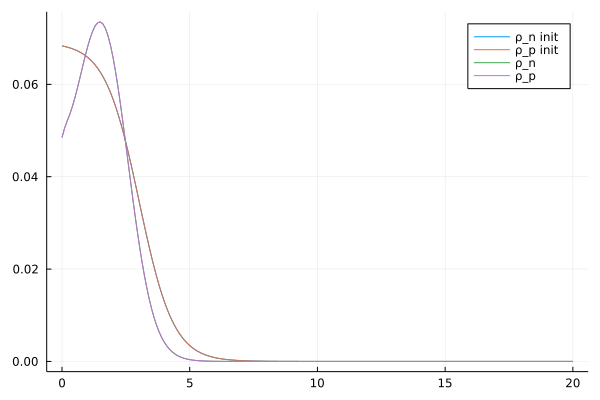

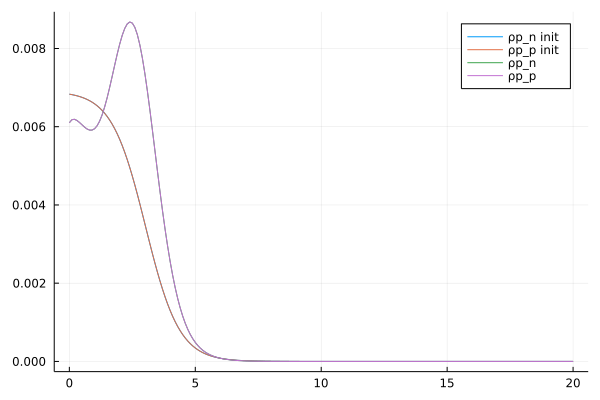

  0.000365 seconds


In [30]:
param = My.PhysicalParam(λ=[-15, -15], Emax=50)
test_calc_density(param)